In [0]:
# from keras.layers import Lambda, Dense, Conv2D, MaxPool2D, Input,Flatten,LeakyReLU, BatchNormalization

%tensorflow_version 1.x  # This is to allow tensorflow v1 with keras.
import keras.backend as K #Import the keras backend that contains basic operations such as Cos, Exp, Log and so on.
from keras.models import Model, Sequential # it will be used to create the models (encoder, decoder, Autoencoder).
from keras.layers import Dense, Input, LeakyReLU, BatchNormalization  # it imports the layer(s) to be used in the contruction.
from keras.losses import mean_squared_error, binary_crossentropy # loss function to be optimized.
from keras.optimizers import SGD, RMSprop, Adam # optimization algorithm.
from keras.datasets import mnist, fashion_mnist # Datasets to be used in the experiments.

import numpy as np
import tqdm

import matplotlib.pyplot as plt # Plot and show stuff
%matplotlib inline


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x  # This is to allow tensorflow v1 with keras.`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


Discriminator
---
The Discriminator is a neural network that classifies if a sample comes from dataset (*real*) or comes from the Generator (*fake*).


In [0]:
def create_discriminator(input_shape=(784,) ): # The function creates and returns the Discriminator Model.
    hidden_size=100 # it is only a parameter that sets the number of neurons in ineer layers of the discriminator
    model = Sequential(name="discriminator")

    model.add(Dense(hidden_size, input_shape=input_shape)) # Input layer
    model.add(LeakyReLU(alpha=0.2)) # Activation function.
    
    model.add(Dense(2*hidden_size))
    model.add(LeakyReLU(alpha=0.2))
   

    model.add(Dense(hidden_size))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation='sigmoid')) # Output layer. with 1 for real and 0 for fake.

    model.summary()

    return model

def create_generator(input_shape=(100,), output_shape=(784,), hidden_size=256):
    model = Sequential(name="Generator")
    model.add(Dense(hidden_size, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(hidden_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(output_shape[0], activation='tanh'))
    model.summary()
    return model

def create_gan(z_size=100): # Combines the generator and discriminator to create GAN
    optimizer = Adam(0.0002, 0.5) # Set the optimization algorithm

    discriminator = create_discriminator() # Create the discriminator
    generator = create_generator() #Create the generator model

    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy']) # Compiles the discriminator setting the optimization algorithm and loss function 

    z = Input(shape=(z_size,)) # Defines the input of the generator (to sample random numbers)
    gen_img = generator(z) # Evaluate the random number transfomring it into an image.

    discriminator.trainable = False # VERY IMPORTANT: Fix the weights of the discriminator when creating the graph of GAN.

    disc_out = discriminator(gen_img) # use the discriminator to evaluate the generated image (fake)

    gan = Model(z, disc_out) # defines the GAN network using the latent z variable as input and discriminator as output.
    gan.compile(loss='binary_crossentropy', optimizer=optimizer) # set the loss and optimizer for the GAN (indeed it is for Generator because generator has its discriminator fixed) 
    return gan, discriminator, generator # Returns the entire gan, discriminator and generator for latter uses.


Generator
---
The generator is a neural 

In [0]:
def load_mnist_data(flatten=True): # Loads, flatten and normalizes the MNIST dataset. 
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # You can use fashion_mnist instead mnist to load the FASHION MNIST
    x_train = x_train.astype('float32')/127.5 -1 # normalize to be in the range [-1, 1]
    x_test = x_test.astype('float32')/127.5-1 # normalize to be in the range [-1, 1]
    if flatten:
        x_train = np.reshape(x_train, (-1, 784)) # Flatten 
        x_test = np.reshape(x_test, (-1, 784)) #Flatten
    
    return x_train, x_test

In [0]:

def save_sample_images(generator, epoch=-1): # Utility to draw the generates images
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100)) #generates random numbers
        gen_imgs = generator.predict(noise) #sends to generator and generate the images.
        

       
        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images in the range [0 - 1]

        fig, axs = plt.subplots(r, c, figsize=(20, 10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                img = np.reshape(gen_imgs[cnt, ...],(28,28)) # Reshape the generate image to be squared (28x28)
                axs[i,j].imshow(img) #, cmap='gray'
                axs[i,j].axis('off')
                cnt += 1

        plt.show()



def train(gan, discriminator, generator,  epochs=10, batch_size=128, size_z=100): #function to train the networks

        # Load the dataset
        x_train, _ = load_mnist_data(flatten=True) 

        
        real = np.ones((batch_size, 1))*1 # Defines 1 for Real image batches
        fake = np.zeros((batch_size, 1)) # Defines 0 for Fake (images created by the generator).
        
        batches = len(x_train)//batch_size # Calculate the amount of batches to train entire dataset

        bar = tqdm.tqdm(range(epochs), position=0, leave=True) #utility library to draw progress bar
        
        for epoch in bar: # Iterate over the epochs
            
            for b in range(batches): # Iterate over the batches

                idx = np.random.randint(0, x_train.shape[0], batch_size) # Randomly choose the batch from the dataset
                imgs = x_train[idx]

                noise = np.random.normal(0, 1, (batch_size, size_z)) # Generate the z latent vector from Gaussian distribution


                gen_imgs = generator.predict(noise) # Using the random vector generates the fake images.

                d_loss_real = discriminator.train_on_batch(imgs, real) # Train the discriminator with Real images and claculates the loss.
                d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # Train the discriminator to detect fake images.
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Calculate the total loss for discriminator.

                # ---------------------
                #  Train Generator
                # ---------------------

                noise = np.random.normal(0, 1, (batch_size, size_z)) # Generates

                # Train the generator (to have the discriminator label samples as real)
                g_loss = gan.train_on_batch(noise, real)

            # Plot the progress
                
                # bar.set_description("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                bar.set_description("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            print("Epochs:{}".format(epoch))
            save_sample_images(generator, epoch)





Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)            

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.633789, acc.: 68.75%] [G loss: 0.638827]:   0%|          | 0/20 [00:02<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
0 [D loss: 0.688179, acc.: 56.25%] [G loss: 1.354440]:   0%|          | 0/20 [00:18<?, ?it/s]

Epochs:0


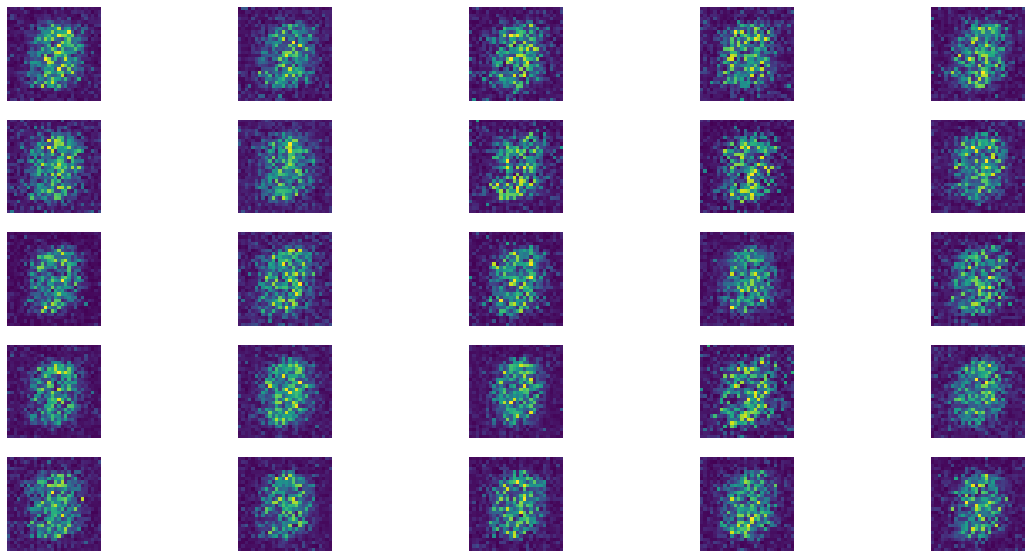

1 [D loss: 0.724705, acc.: 39.84%] [G loss: 0.852828]:   5%|▌         | 1/20 [00:36<06:13, 19.64s/it]

Epochs:1


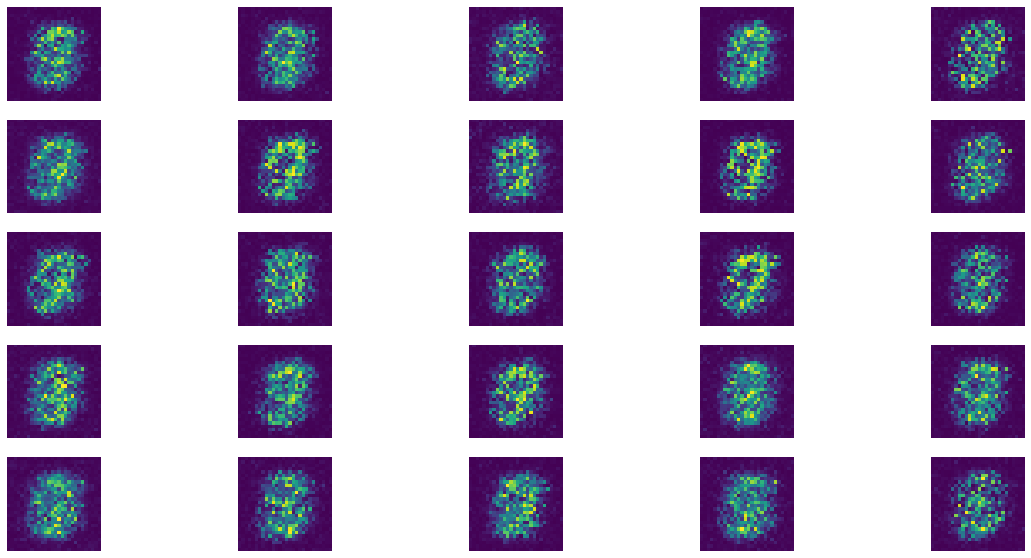

2 [D loss: 0.718865, acc.: 36.72%] [G loss: 0.799254]:  10%|█         | 2/20 [00:53<05:41, 18.99s/it]

Epochs:2


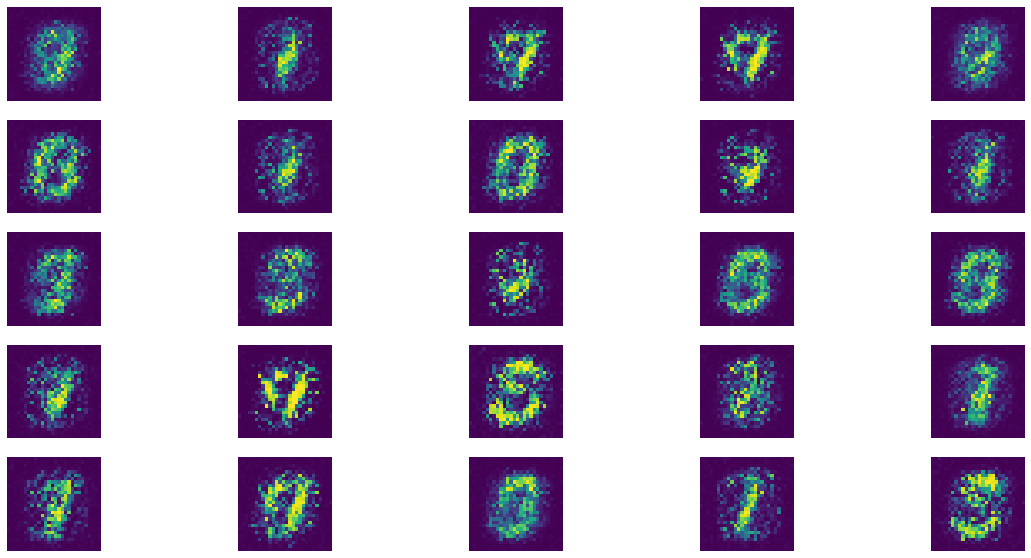

3 [D loss: 0.720660, acc.: 39.45%] [G loss: 0.809318]:  15%|█▌        | 3/20 [01:11<05:14, 18.48s/it]

Epochs:3


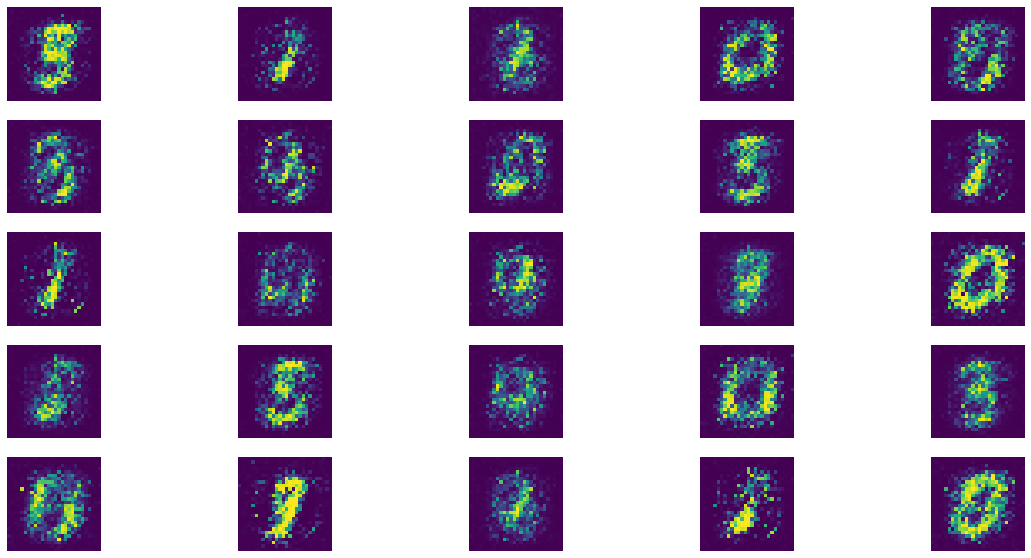

4 [D loss: 0.681029, acc.: 50.39%] [G loss: 0.858561]:  20%|██        | 4/20 [01:29<04:51, 18.21s/it]

Epochs:4


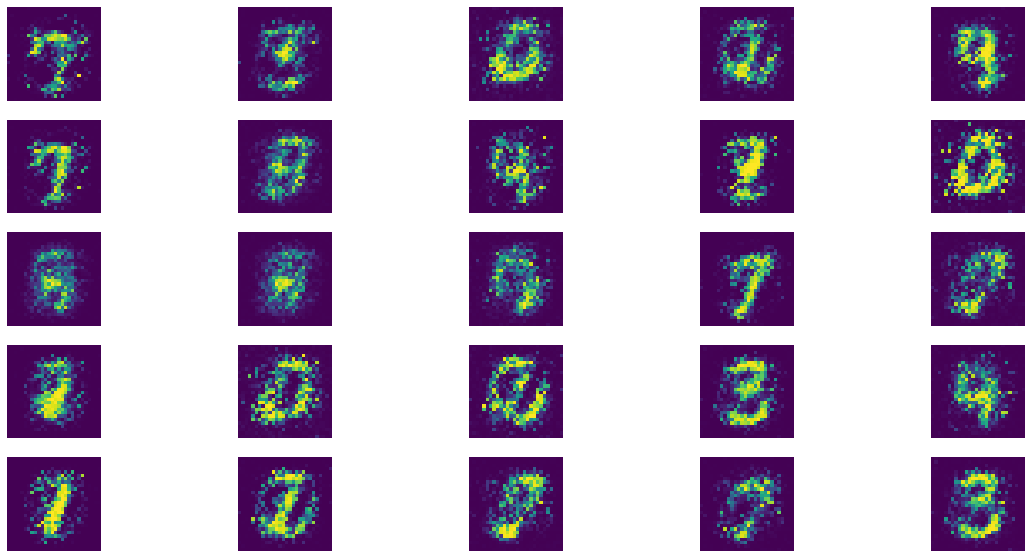

5 [D loss: 0.675243, acc.: 58.59%] [G loss: 0.837712]:  25%|██▌       | 5/20 [01:46<04:31, 18.07s/it]

Epochs:5


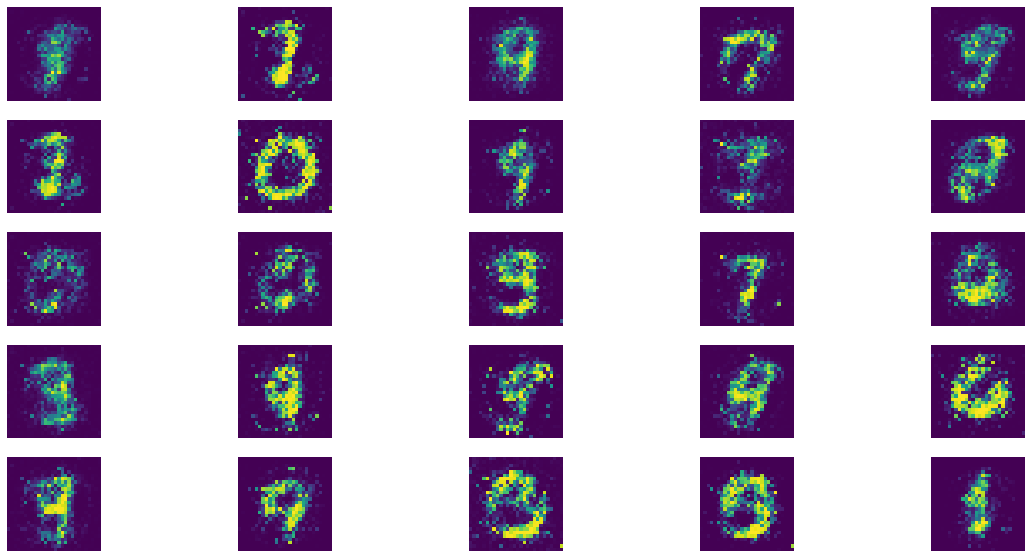

6 [D loss: 0.667722, acc.: 59.77%] [G loss: 0.905759]:  30%|███       | 6/20 [02:03<04:10, 17.90s/it]

Epochs:6


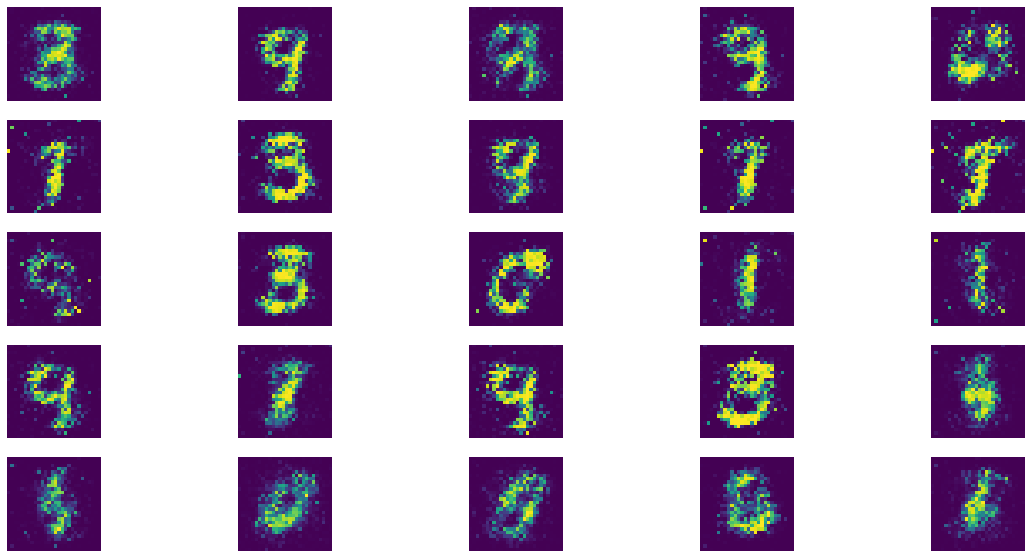

7 [D loss: 0.671332, acc.: 58.98%] [G loss: 0.833045]:  35%|███▌      | 7/20 [02:20<03:49, 17.68s/it]

Epochs:7


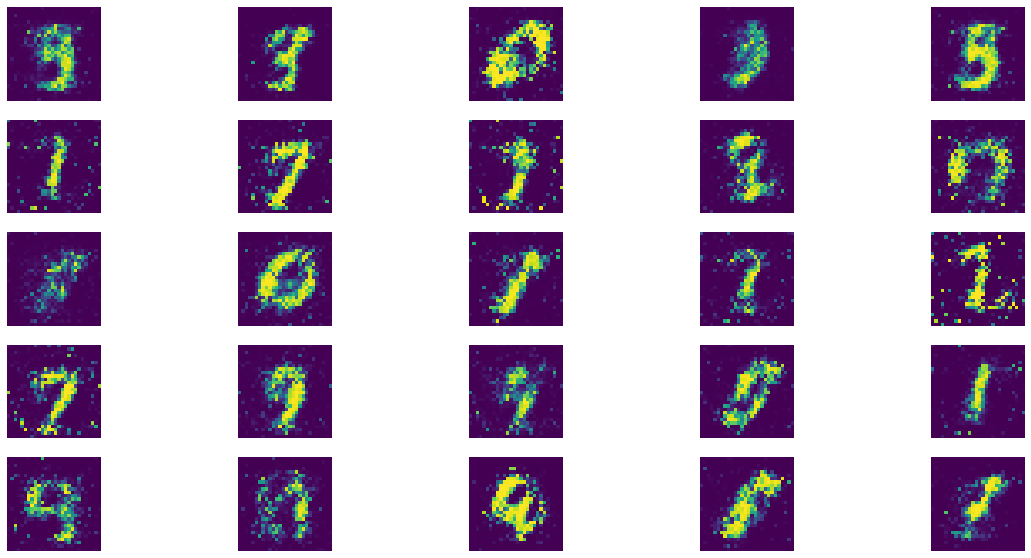

8 [D loss: 0.639124, acc.: 57.03%] [G loss: 0.866255]:  40%|████      | 8/20 [02:38<03:30, 17.56s/it]

Epochs:8


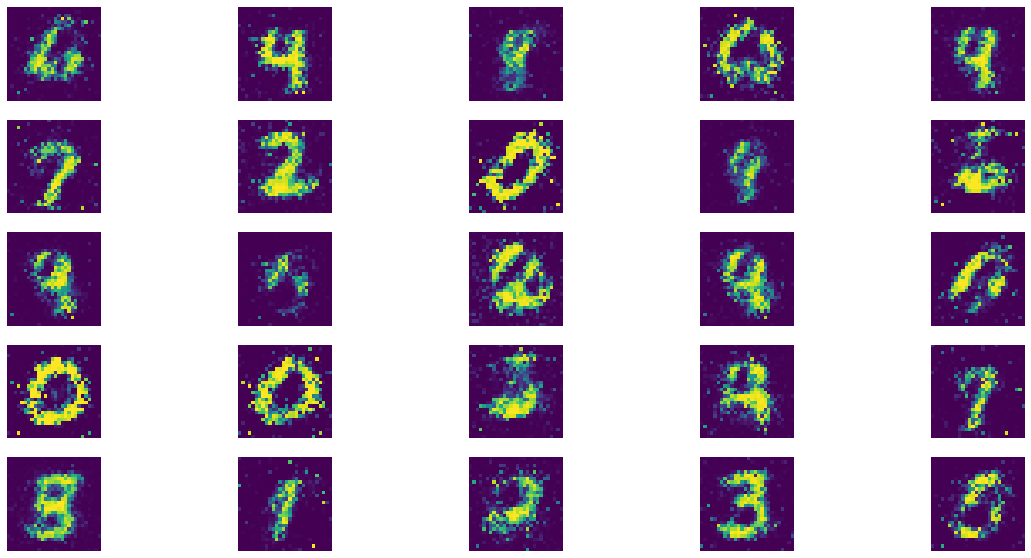

9 [D loss: 0.647600, acc.: 61.72%] [G loss: 0.865946]:  45%|████▌     | 9/20 [02:55<03:11, 17.44s/it]

Epochs:9


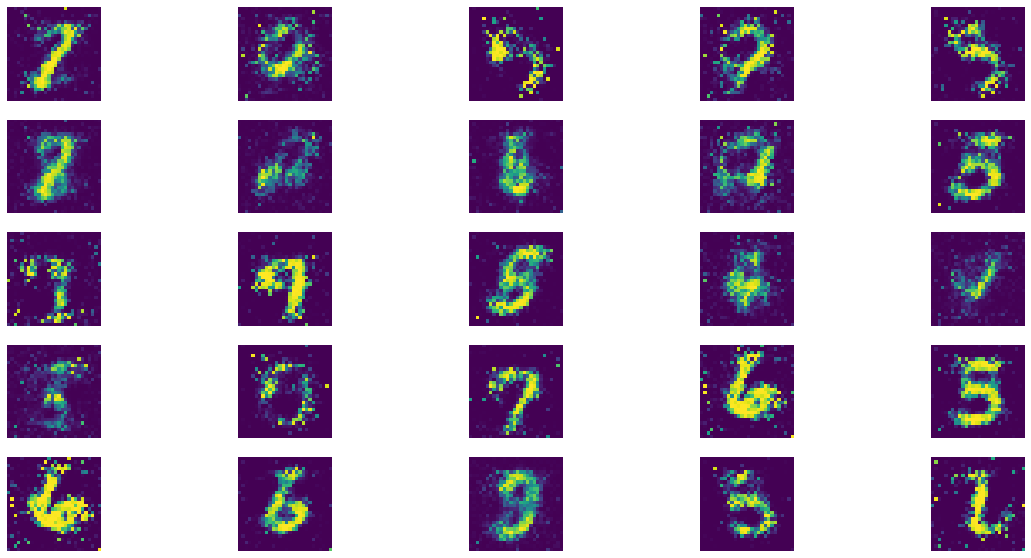

10 [D loss: 0.652179, acc.: 58.98%] [G loss: 0.858090]:  50%|█████     | 10/20 [03:12<02:54, 17.40s/it]

Epochs:10


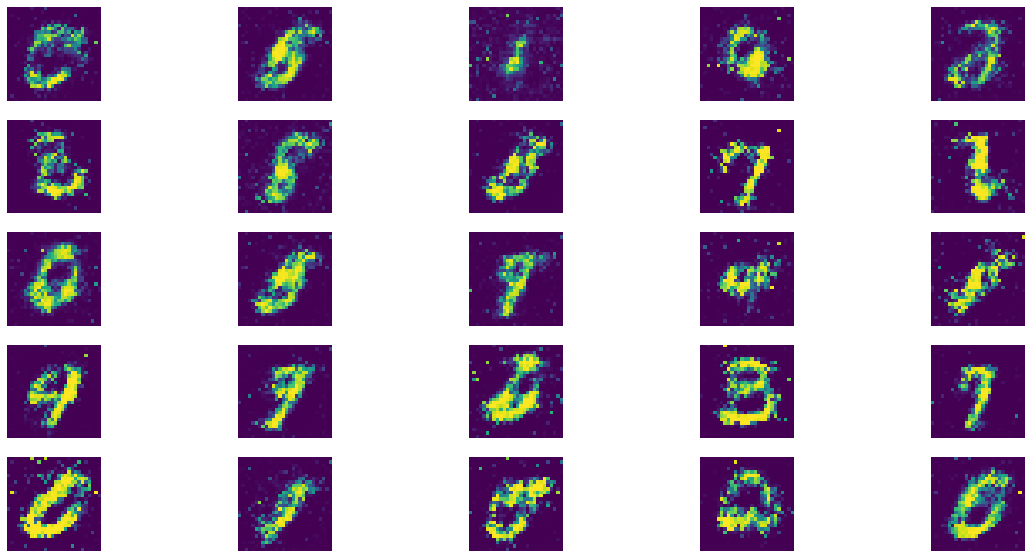

11 [D loss: 0.679121, acc.: 58.20%] [G loss: 0.869361]:  55%|█████▌    | 11/20 [03:29<02:36, 17.34s/it]

Epochs:11


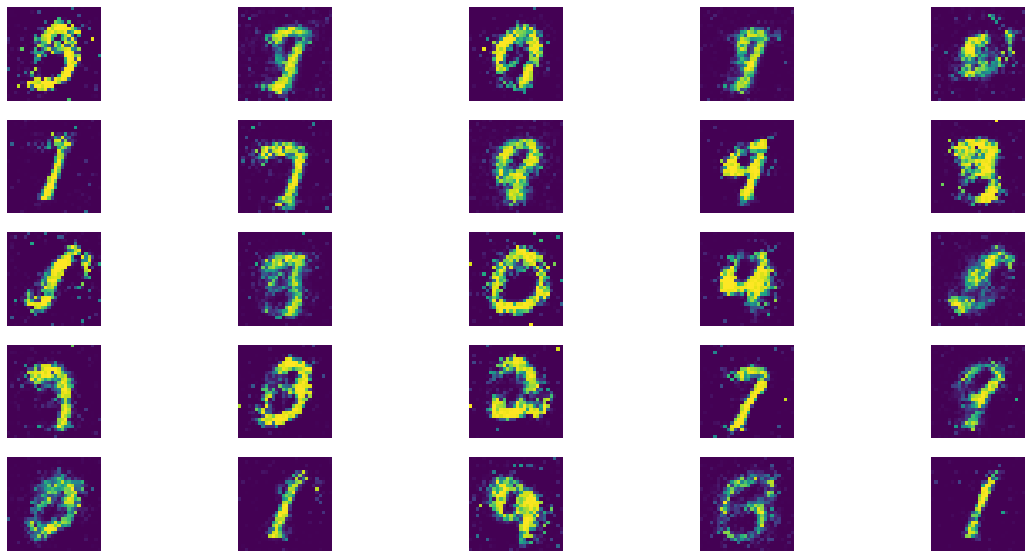

12 [D loss: 0.697325, acc.: 52.73%] [G loss: 0.835819]:  60%|██████    | 12/20 [03:47<02:18, 17.32s/it]

Epochs:12


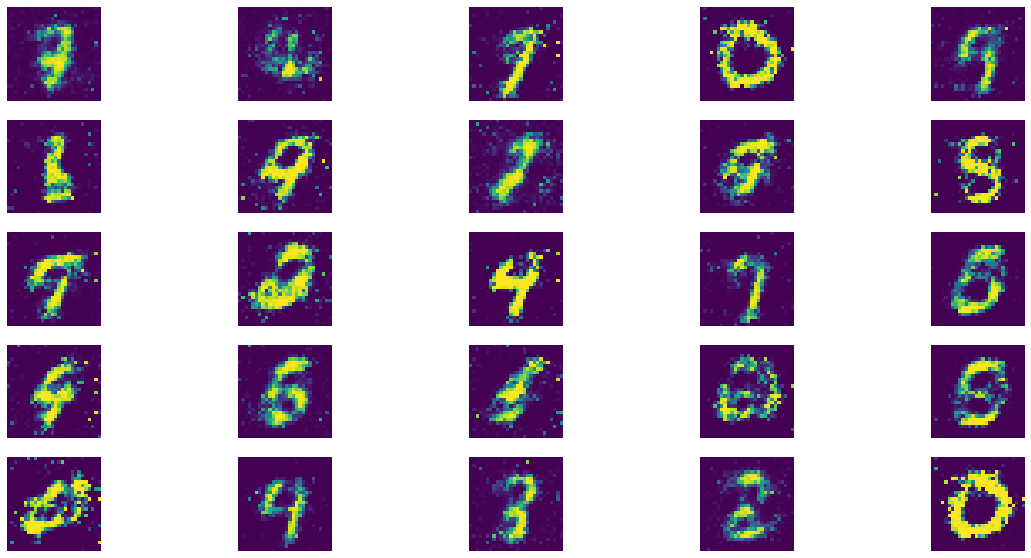

13 [D loss: 0.655598, acc.: 57.81%] [G loss: 0.851821]:  65%|██████▌   | 13/20 [04:04<02:01, 17.29s/it]

Epochs:13


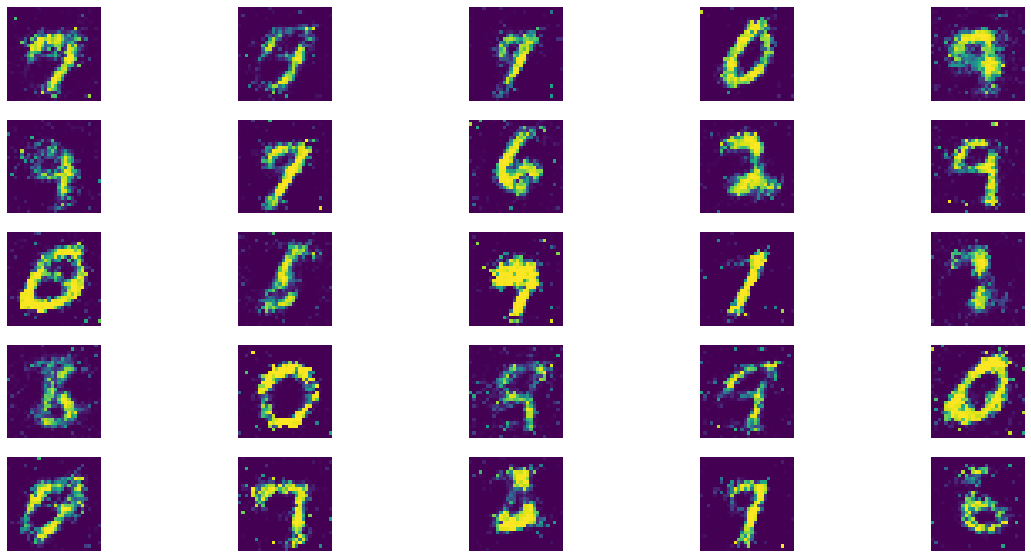

14 [D loss: 0.652457, acc.: 60.55%] [G loss: 0.848737]:  70%|███████   | 14/20 [04:21<01:43, 17.29s/it]

Epochs:14


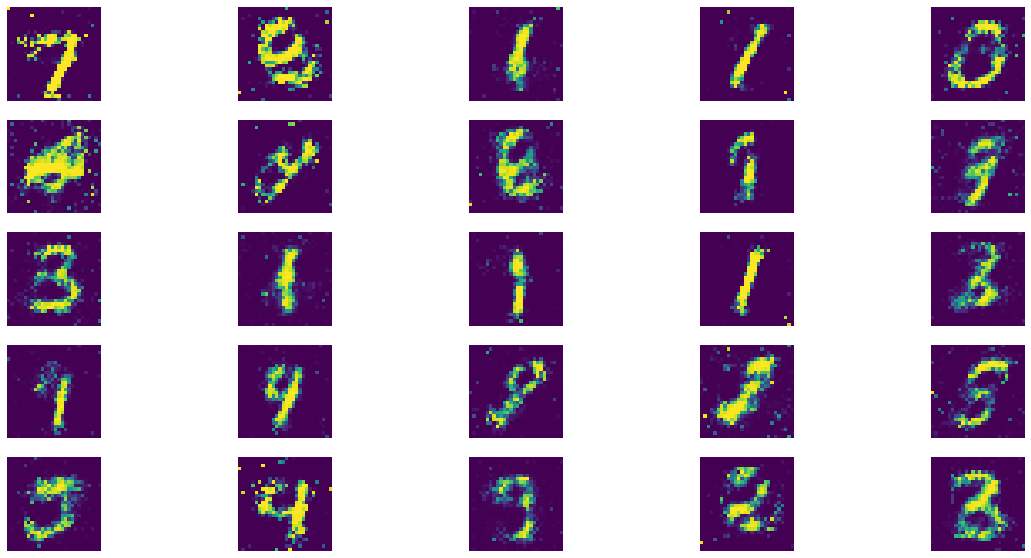

15 [D loss: 0.669844, acc.: 60.16%] [G loss: 0.847467]:  75%|███████▌  | 15/20 [04:38<01:26, 17.31s/it]

Epochs:15


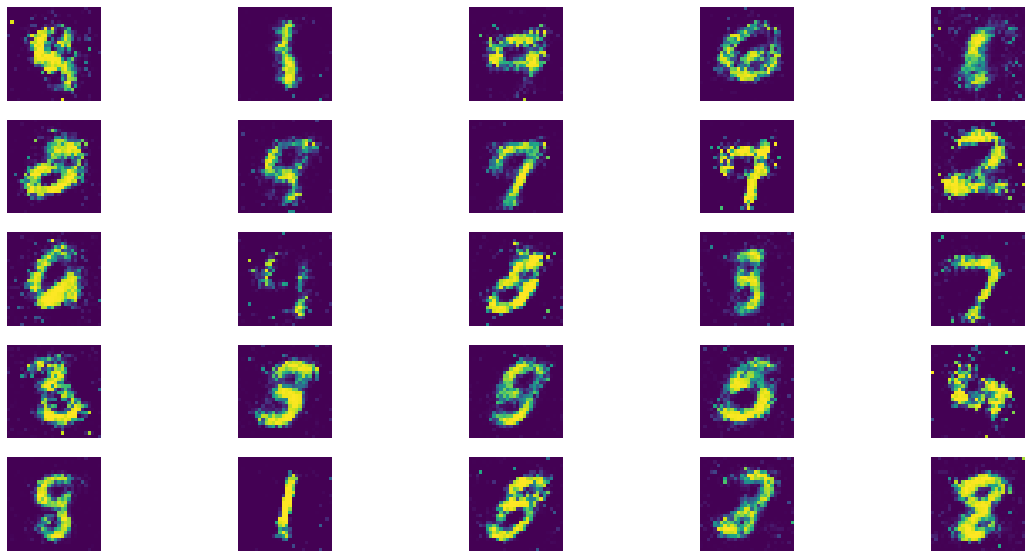

16 [D loss: 0.677381, acc.: 57.42%] [G loss: 0.846790]:  80%|████████  | 16/20 [04:56<01:09, 17.31s/it]

Epochs:16


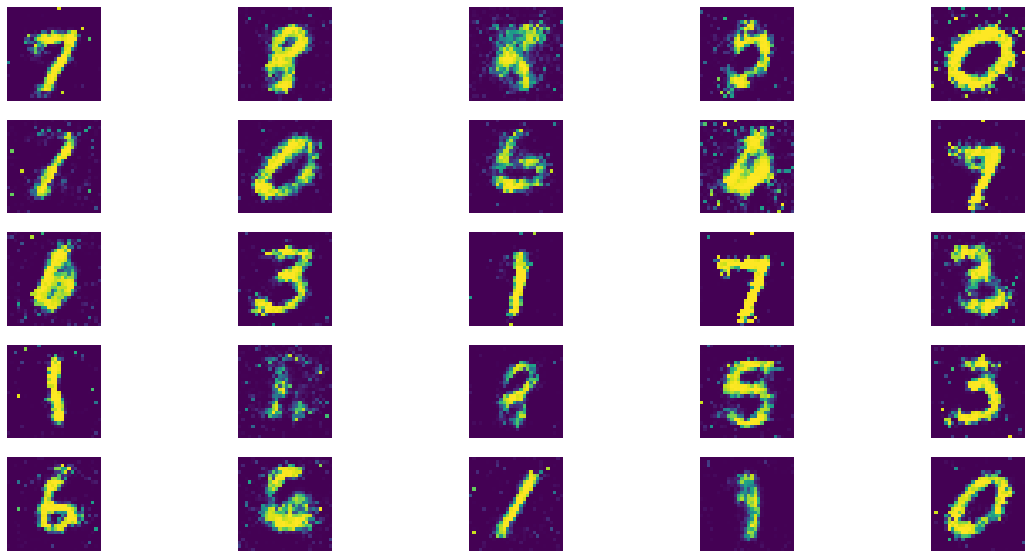

17 [D loss: 0.669739, acc.: 58.98%] [G loss: 0.859697]:  85%|████████▌ | 17/20 [05:13<00:51, 17.29s/it]

Epochs:17


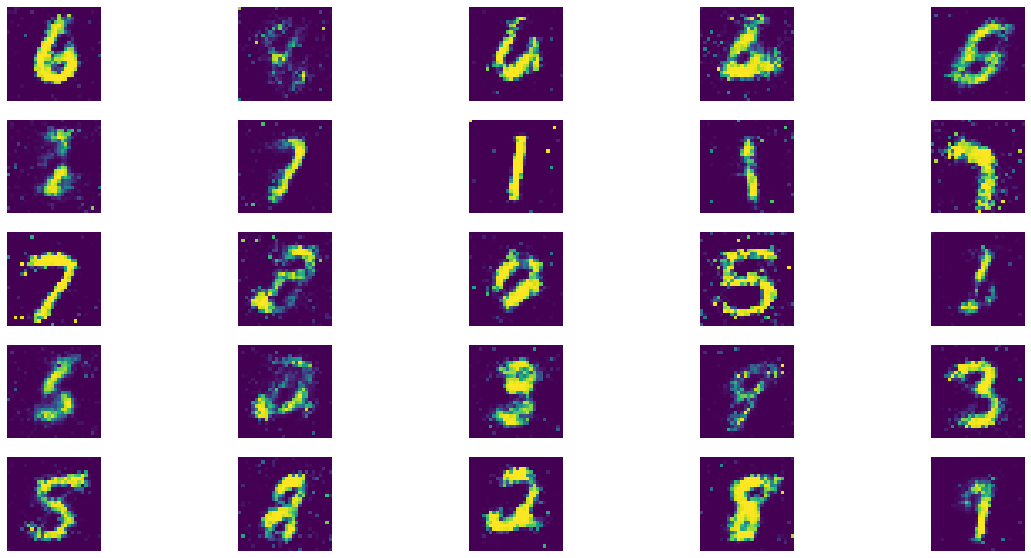

18 [D loss: 0.661423, acc.: 59.77%] [G loss: 0.888131]:  90%|█████████ | 18/20 [05:31<00:34, 17.29s/it]

Epochs:18


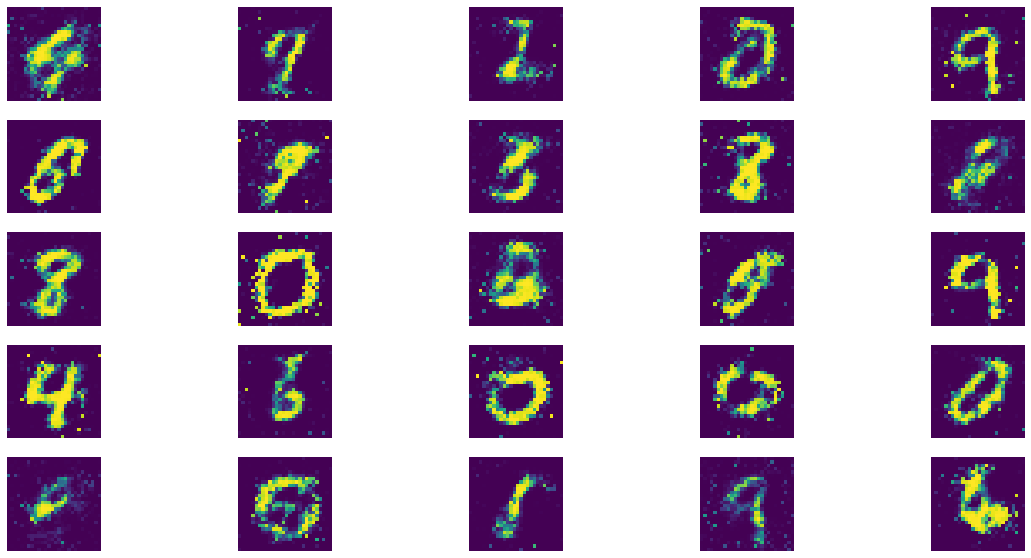

19 [D loss: 0.660423, acc.: 63.28%] [G loss: 0.887994]:  95%|█████████▌| 19/20 [05:48<00:17, 17.34s/it]

Epochs:19


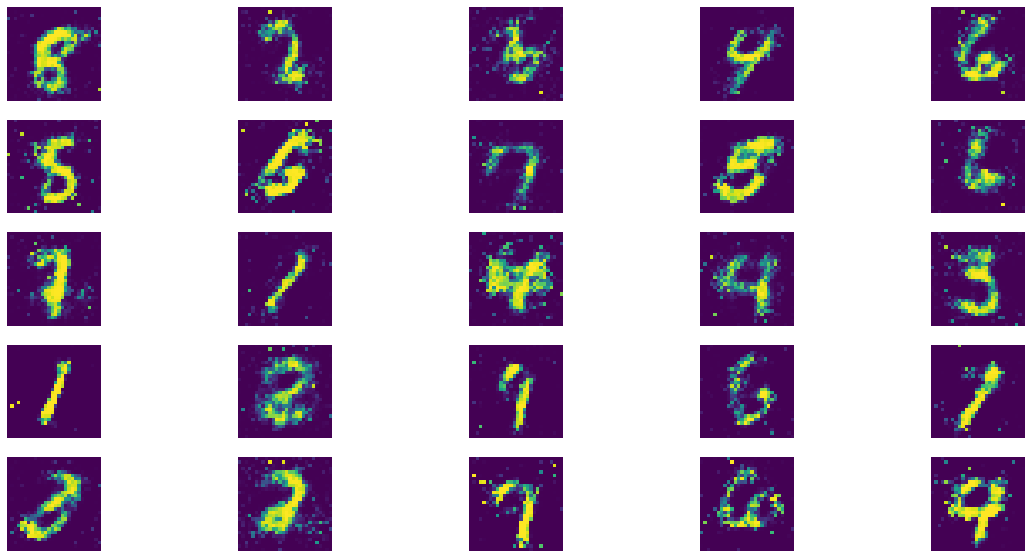

19 [D loss: 0.660423, acc.: 63.28%] [G loss: 0.887994]: 100%|██████████| 20/20 [05:49<00:00, 17.44s/it]


In [0]:
gan, discriminator, generator = create_gan()

train(gan,discriminator, generator, epochs=20)

(100, 784)


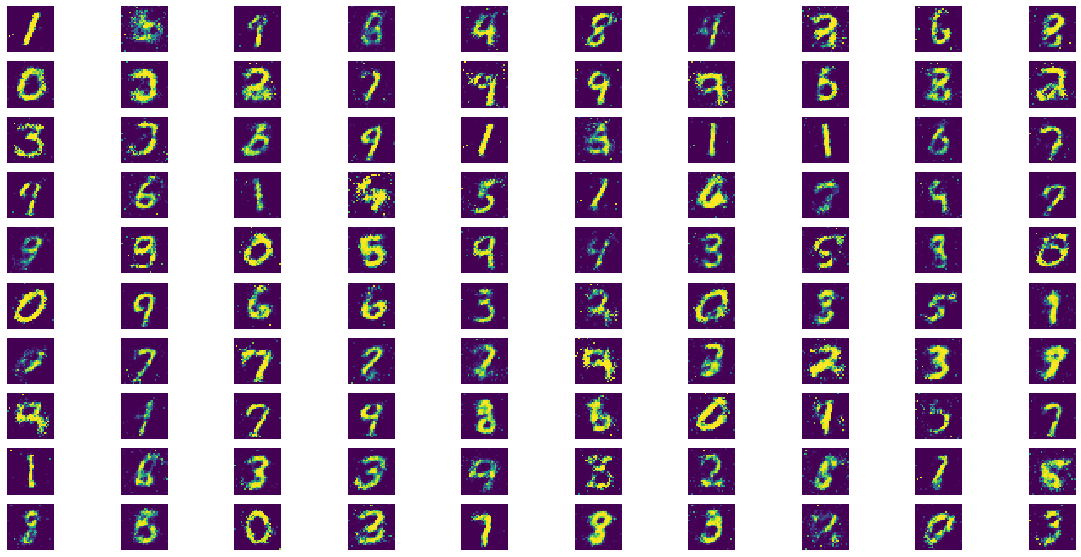

In [0]:

def sample_images(generator, epoch=-1):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)
        print(gen_imgs.shape)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(20, 10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                img = np.reshape(gen_imgs[cnt, ...],(28,28))
                axs[i,j].imshow(img)
                axs[i,j].axis('off')
                cnt += 1
       
        plt.show()

sample_images(generator)

Tasks
---

1. Train the GAN with MNIST for 20 or more epochs. What is the behavior of the Discriminator accuracy along the training phase. 

2. With a trained model, generate images sampling the generator with with differnt gaussian mean and stadard deviation. How those parameters affects the generated images?

3. Apply softlabeling, making the Real data be labeled as 0.9 instead 1. What is the effect of the soft-labeling for the image quality? How is the evolution of discriminator accuracy?  

3. Add Layers to the discriminator and retrain. How the the layers affects the quality of the generated images?

4. Comment out the BatchNormalization layer from Generator. What is the impact of the batch normalization absance?

5. Repeat the steps 1-4 for the mnist dataset. Do you conclusions obtained early applies for the new dataset? 

